In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/similarity_matrix/"

# List all files in the directory
all_files = os.listdir(PATH)
print(all_files)

# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)

['similarity_HDpA00dUifZ5.csv', 'similarity_4U-z2a8-4LfC.csv', 'similarity_RO9MDopzUfHo.csv', 'similarity_EcDBPfOd-tji.csv', 'similarity_SATFc0U1XHrJ.csv', 'similarity_75wfB613llIF.csv', 'similarity_wxzd30CsS09m.csv', 'similarity_U5cKPUTMu0fs.csv', 'similarity_C16oRDnCUik-.csv', 'similarity_oItkDMGyE_uL.csv', 'similarity_W6WhLTeFA3RT.csv', 'similarity_MNOjIfAeZSV4.csv', 'similarity_c92RUDpQdRsV.csv', 'similarity_T2iKQFAiXP15.csv', 'similarity_-N2FwY4uC3d7.csv', 'similarity_bOSChw4Ipatb.csv', 'similarity_rkFen2Hs6Lbo.csv', 'similarity_dn-ArUl4FIUe.csv', 'similarity_5U61OcE1cgW_.csv', 'similarity_J1cfSjiD0iD9.csv', 'similarity_epAx1MybHBcL.csv', 'similarity_2NtvG4WqOd1S.csv', 'similarity_IZr3eFPWcYod.csv', 'similarity_qOGaFEyNVUMh.csv', 'similarity_7kH-L_CWn-kl.csv', 'similarity_SK80lPsgpYX3.csv', 'similarity_3noC1OdWbTjA.csv', 'similarity_Gq5JcPdzhkpL.csv', 'similarity_7ov4Ahb_Kg1n.csv', 'similarity_PuVT9SuHD_RF.csv', 'similarity_5DWiLmu6c6u7.csv', 'similarity_0xpBKXpjmT2Z.csv', 'simila

In [52]:
# Take a sample
sample = pd.read_csv(PATH + "similarity_bOSChw4Ipatb.csv", index_col=0)

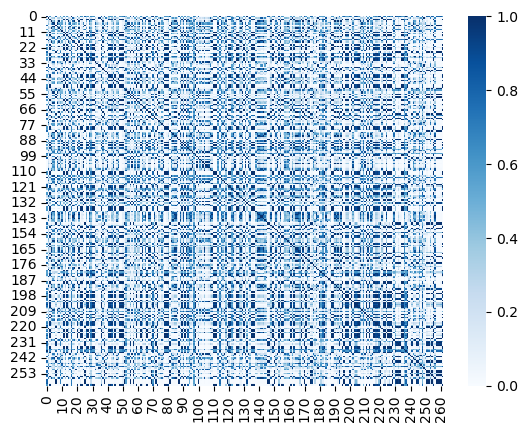

In [53]:
def recurrent_plot(df):
    # Viz
    sns.heatmap(df, cmap="Blues")


recurrent_plot(sample)

Most stable score 0.9151413577010462 at day 225


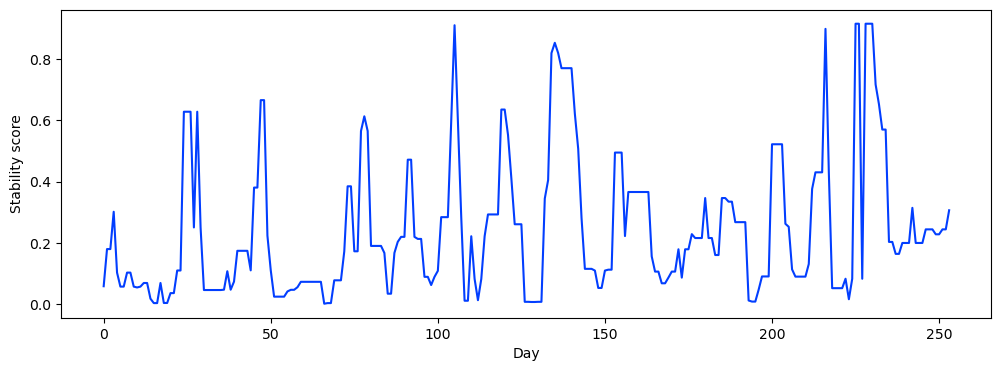

In [54]:
def stability_score(similarity_matrix, kernel_size=7):
    size = similarity_matrix.shape[0] - kernel_size - 1
    # Extract the similarity values of consecutive elements
    consecutive_similarity = np.diag(
        similarity_matrix, k=1
    )  # k=1 for one above the main diagonal

    stability_scores = []
    for i in range(0, size):
        kernel = consecutive_similarity[i : i + kernel_size]
        stability_scores.append(np.median(kernel))
    # Slide
    return stability_scores


score = stability_score(sample)

# Plot
plt.figure(figsize=(12, 4))
plt.xlabel("Day")
plt.ylabel("Stability score")
sns.lineplot(score)

print(f"Most stable score {np.max(score)} at day {np.argmax(score)}")

In [57]:
# Load feature momo
DATA_PATH = "data/processed/momo/similarity_matrix/"
fp = "/m/cs/work/luongn1/digirhythm/data/processed/momo/vector_momo.pkl"
df = pd.read_pickle(fp)
df

,user,date,group,location:dist_total:night,location:dist_total:morning,location:dist_total:afternoon,location:dist_total:evening,location:entropy:night,location:entropy:morning,location:entropy:afternoon,...,call:incoming_duration_total:sum,call:incoming_duration_total:night:norm,call:incoming_duration_total:morning:norm,call:incoming_duration_total:afternoon:norm,call:incoming_duration_total:evening:norm,call:outgoing_duration_total:sum,call:outgoing_duration_total:night:norm,call:outgoing_duration_total:morning:norm,call:outgoing_duration_total:afternoon:norm,call:outgoing_duration_total:evening:norm
0,0xpBKXpjmT2Z,2021-02-10,mmm-bpd,0.921878,82.008263,9.459394,1.135182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3102.0,0.0,0.0,1.0,0.0
1,0xpBKXpjmT2Z,2021-02-11,mmm-bpd,0.665031,3.330631,6.764745,2.521860,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0xpBKXpjmT2Z,2021-02-12,mmm-bpd,0.782884,4.236780,1.032637,0.466304,0.0,0.0,0.0,...,1010.0,0.0,0.0,1.0,0.0,313.0,0.0,0.0,1.0,0.0
3,0xpBKXpjmT2Z,2021-02-13,mmm-bpd,1.014298,1.560544,0.861583,9.600162,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0xpBKXpjmT2Z,2021-02-14,mmm-bpd,0.014538,0.630028,14.213525,3.249465,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13887,tZc-k6nnwAxS,2021-08-26,mmm-control,0.000000,1.648893,0.145864,30.490729,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13888,tZc-k6nnwAxS,2021-08-27,mmm-control,0.000000,0.118942,0.521250,1.535611,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2928.0,0.0,0.0,1.0,0.0
13889,tZc-k6nnwAxS,2021-04-13,mmm-control,0.000000,1.407586,1.105643,1.792539,0.0,0.0,0.0,...,937.0,0.0,0.0,0.0,1.0,597.0,0.0,0.0,0.0,1.0
13890,tZc-k6nnwAxS,2021-01-27,mmm-control,0.000000,0.175669,0.169621,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0
